## Using rankseg with Segment Anything Model (SAM)

This notebook shows how to use rankseg as a postprocessing step for SAM.

### 0. Download packages and define utility functions

In [3]:
!pip install rankseg transformers

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points_on_image(raw_image, input_points, input_labels=None):
  plt.figure(figsize=(10,10))
  plt.imshow(raw_image)
  input_points = np.array(input_points)
  if input_labels is None:
    labels = np.ones_like(input_points[:, 0])
  else:
    labels = np.array(input_labels)
  show_points(input_points, labels, plt.gca())
  plt.axis('on')
  plt.show()

def show_points(coords, labels, ax, marker_size=375):
  pos_points = coords[labels==1]
  neg_points = coords[labels==0]
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


### 1. Prepare SAM model and example data

In [5]:
import torch
from transformers import SamModel, SamProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

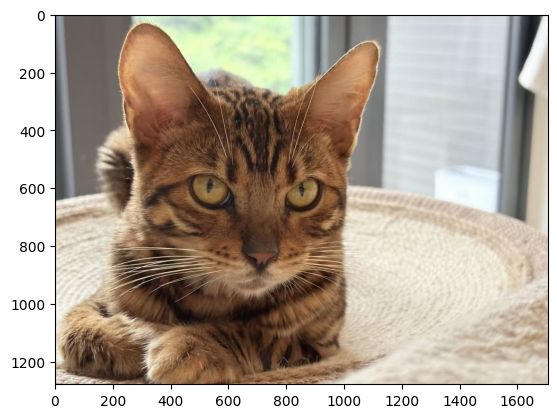

In [6]:
from PIL import Image
import requests

img_url = "https://huggingface.co/datasets/ZixunWang/rankseg-demo/resolve/main/barney.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

plt.imshow(raw_image)

### 3. Image embedding and prepare input points

In [7]:
inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

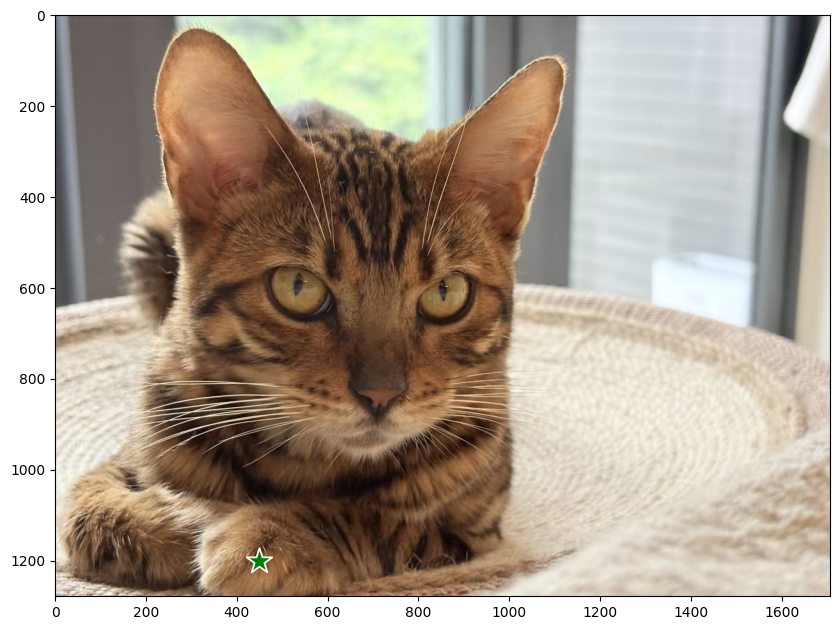

In [8]:
input_points = [[[450, 1200]]]
show_points_on_image(raw_image, input_points[0])

### 4. Segmentation

We first use SAM to obtain binary logits, which are then used to generate final masks by either **thresholding** or **rankseg**.

In [9]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

logits = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu(), binarize=False)[0][0]

# traditional threshold/argmax prediction
threshold_preds = logits > 0.

# rankseg prediction
from rankseg import RankSEG
probs = logits.sigmoid()
rankseg = RankSEG(metric='iou', solver='RMA', output_mode='multilabel')
rankseg_preds = rankseg.predict(probs)

### 5. Visualize results

We can see that for the prediction 2, rankseg delivers more accurate result around ears.

/tmp/ipython-input-3871988445.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)


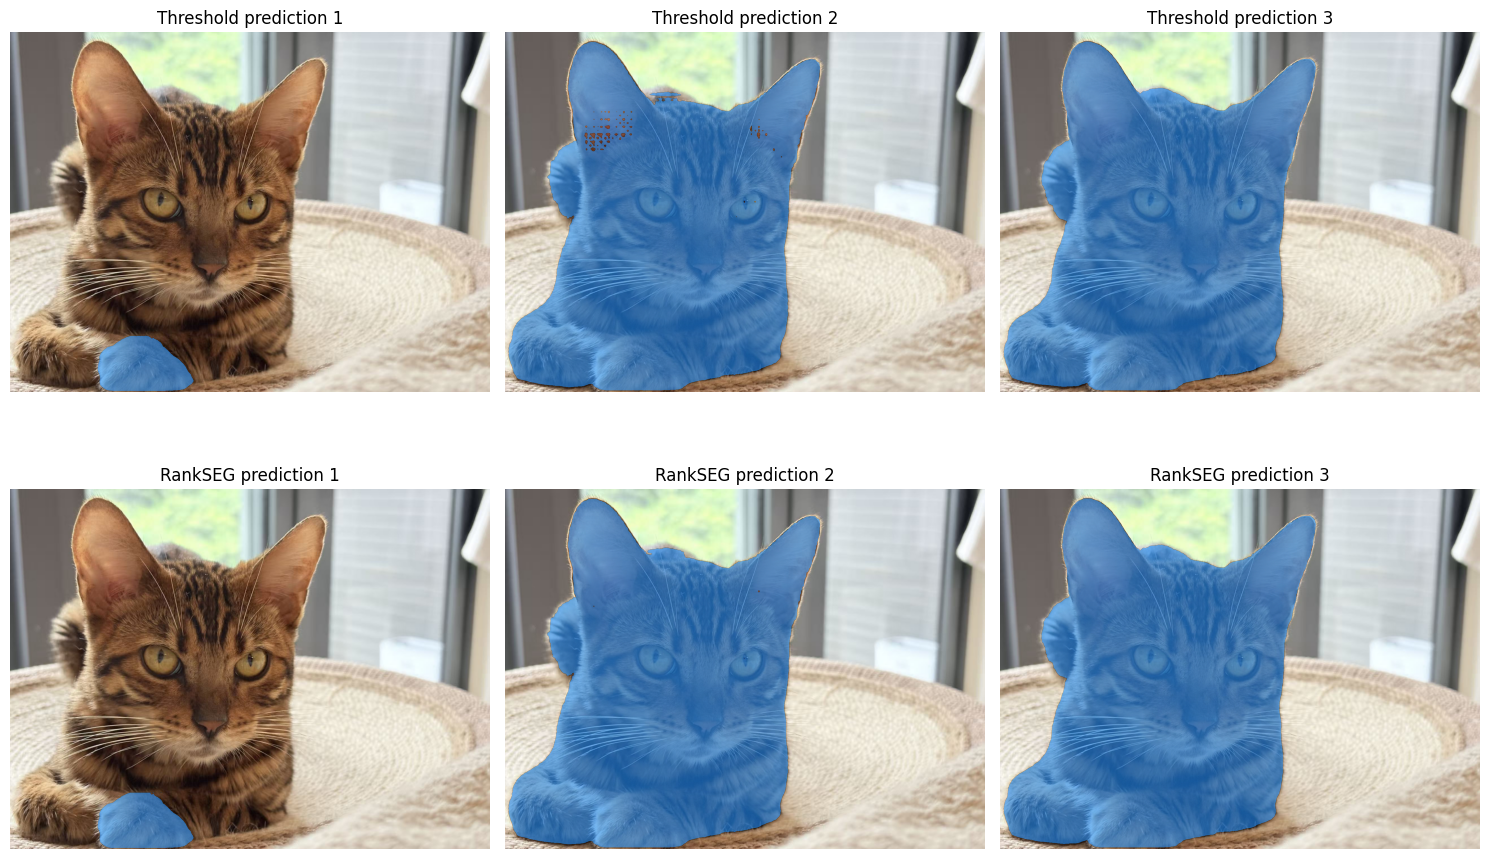

In [11]:
num_predictions = logits.shape[0]
fig, axes = plt.subplots(2, num_predictions, figsize=(15, 10))
for i, (threshold_pred, rankseg_pred) in enumerate(zip(threshold_preds, rankseg_preds)):
    threshold_pred = threshold_pred.cpu().detach()
    rankseg_pred = rankseg_pred.cpu().detach()

    axes[0, i].imshow(np.array(raw_image))
    show_mask(threshold_pred, axes[0, i])
    axes[0, i].title.set_text(f"Threshold prediction {i+1}")
    axes[0, i].axis("off")

    axes[1, i].imshow(np.array(raw_image))
    show_mask(rankseg_pred, axes[1, i])
    axes[1, i].title.set_text(f"RankSEG prediction {i+1}")
    axes[1, i].axis("off")

plt.tight_layout()